In [27]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np

### Reading in and viewing all data frames:

In [28]:
earthtemp = pd.read_csv('clean_data/earthtemp.csv', index_col = 0)
earthtemp.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,Year,Month
2136,2006-01-01,-8.118,0.400,2006,1
2137,2006-02-01,-8.231,0.244,2006,2
2138,2006-03-01,-5.795,0.326,2006,3
2139,2006-04-01,2.137,0.244,2006,4
2140,2006-05-01,6.813,0.342,2006,5


In [29]:
population = pd.read_csv("clean_data/population.csv", index_col = 0)
population.head()

,Region,Municipality,Year,Total,source_x,value_x,sector,source_y,value_y
0,1003,Elkford,2006,"2,545",BIOMASS,10.615334,TOTAL DEMAND,OIL,457.0888
9,1006,Sparwood,2006,"3,736",BIOMASS,10.615334,TOTAL DEMAND,OIL,457.0888
18,1012,Fernie,2006,"4,324",BIOMASS,10.615334,TOTAL DEMAND,OIL,457.0888
27,1022,Cranbrook,2006,"18,791",BIOMASS,10.615334,TOTAL DEMAND,OIL,457.0888
36,1028,Kimberley,2006,"6,283",BIOMASS,10.615334,TOTAL DEMAND,OIL,457.0888


In [30]:
powercons=pd.read_csv('clean_data/powercon.csv', index_col = 0)
powercons.head()

,sector,source,Year,value
1,TOTAL DEMAND,OIL,2006,457.0888
2,TOTAL DEMAND,NATURAL GAS,2007,321.0989
6,TOTAL DEMAND,OIL,2009,430.8465
7,TOTAL DEMAND,BIOMASS,2010,204.5951
8,TOTAL DEMAND,NATURAL GAS,2010,305.5171


In [31]:
powergen = pd.read_csv('clean_data/powergen.csv', index_col = 0)
powergen.head()

,source,Year,value
8,BIOMASS,2006,10.615334
11,NATURAL GAS,2006,8.599036
12,OIL,2006,0.128002
16,BIOMASS,2007,10.615334
19,NATURAL GAS,2007,8.599032


In [32]:
precipitation = pd.read_csv('clean_data/precipitation.csv',index_col = 0)
precipitation.head()

,ONE_DAY_PRECIPITATION,MIN_TEMP,MAX_TEMP,Station,Year,Month
12,5.9,-6.7,-3.7,MIS,2006,1
13,13.8,-7.2,-0.8,MIS,2006,2
14,0.0,-11.4,2.3,MIS,2006,3
15,0.0,-5.9,6.5,MIS,2006,4
16,10.4,-7.1,1.9,MIS,2006,5


In [42]:
# some code from https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
def fit_regression_model(data, response):
    # Params: 
    # data: pd.DataFrame -> dataframe to regress on
    # response: string -> the name of the response variable 
    # alpha: float -> the value of alpha to use in the Ridge regressor
    
    # Function fits a Ridge regression model to the specified response from Year, returns the fitted model, 
    # the R^2 score and predictions for the years 2014-2030.
    
    ridge = LinearRegression()
    X = data[['Year']]
    y = data[response]
    ridge.fit(X,y)
    
    score = ridge.score(X,y)
    
    new_years = np.arange(2014, 2035, 1).reshape(-1,1)
    preds = ridge.predict(new_years)
    
    return ridge, score, preds

In [57]:
def plot_old_and_preds(data, preds, model, response):
    # Params:
    # data: pd.DataFrame -> data to plot/predict from
    # preds: np.array -> predictions from previous regression model
    # model: LinearRegression instance -> the model fit to the data
    # response: String -> name of response variable
    
    # Function predicts values for years 2005-2035 using the previously fitted model, then plots the predictions
    # against the true values.
    
    # Returns matplotlib plot
    
    years = np.arange(2005, 2035, 1).reshape(-1,1)
    preds = model.predict(years)
    data_years = data['Year'].values
    data_vals = data[response].values
    
    plt.plot(years, preds, color = 'blue', label = 'Prediction')
    plt.plot(data_years, data_vals, color = 'red', label = 'Real Data')
    plt.xlabel("Year")
    plt.ylabel(response)
    plt.legend()
    
    plt.show()
    

In [58]:
# Fitting temperature model
et_model, et_score, et_preds = fit_regression_model(earthtemp, 'AverageTemperature')
et_preds

/Applications/miniconda3/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([2.16796519, 2.37656603, 2.58516687, 2.79376772, 3.00236856,
       3.21096941, 3.41957025, 3.6281711 , 3.83677194, 4.04537279,
       4.25397363, 4.46257447, 4.67117532, 4.87977616, 5.08837701,
       5.29697785, 5.5055787 , 5.71417954, 5.92278038, 6.13138123,
       6.33998207])

/Applications/miniconda3/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


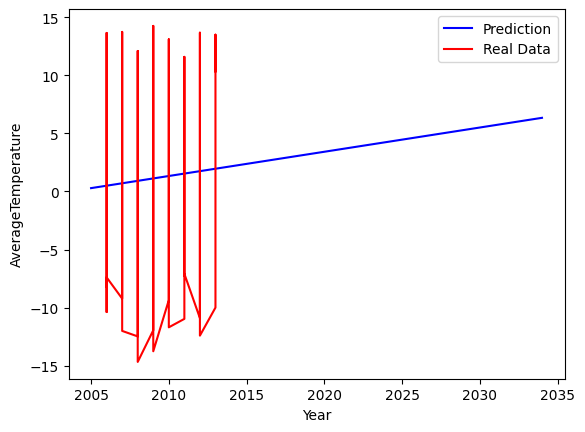

In [59]:
# Plotting temperature model
plot_old_and_preds(earthtemp, et_preds, et_model, 'AverageTemperature')